# Import with Neo4j-admin
Workflow:
- neo4j-admin import
- create db, add constraints and indexes
- consistency check

## Follow this step on your shell

Start docker:
```
docker compose -d
```

Go to the container's shell

```
docker exec -it neo4j_server /bin/bash
```

After that, you can use neo4j-admin command 
```
neo4j-admin database import full movies --overwrite-destination --id-type=integer --nodes import/users.csv import/movies.csv import/genres.csv --relationships import/ratings.csv import/movies_genres.csv
```
if you have this massage `The database is in use. Stop database 'movies' and try again.`.  
Execute `neo4j stop` and enter again on container's shell with `docker exec -it neo4j_server /bin/bash`
!! neo4j-admin import create database from zero.  

After that the result output should be that:  
![neo4j_admin_import_results.png](images/neo4j_admin_import_results.png)

Create database with the next cell

In [2]:
from neo4j import GraphDatabase

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

driver = GraphDatabase.driver(URI)

driver.verify_connectivity()
print("Successfully connected to Neo4j")

session = driver.session(database="system")

if [NAME_DB] in session.run("SHOW DATABASE yield name;").values():
    print("Database already exists")
else:
    session.run(f"CREATE DATABASE {NAME_DB};")
    print("Database created")
session = driver.session(database=NAME_DB)

Successfully connected to Neo4j
Database created


Maybe at this point, you could need to restart neo4j in the docker container shell with 
```
neo4j restart
``` 

In [3]:
# CONSTRAINTS for unique IDs
session.run(
    """
    CREATE CONSTRAINT UniqueMovieID IF NOT EXISTS 
    FOR (m:Movie) 
    REQUIRE m.id IS unique;
    """
)
session.run(
    """
    CREATE CONSTRAINT UniqueUserID IF NOT EXISTS 
    FOR (u:User) 
    REQUIRE u.id IS unique;
    """
)
session.run(
    """
    CREATE CONSTRAINT UniqueGenreID IF NOT EXISTS 
    FOR (g:Genre) 
    REQUIRE g.id IS unique;
    """
)

After creating the constraints, neo4j also creates the range indexes for the necessary ids and lookup indices.

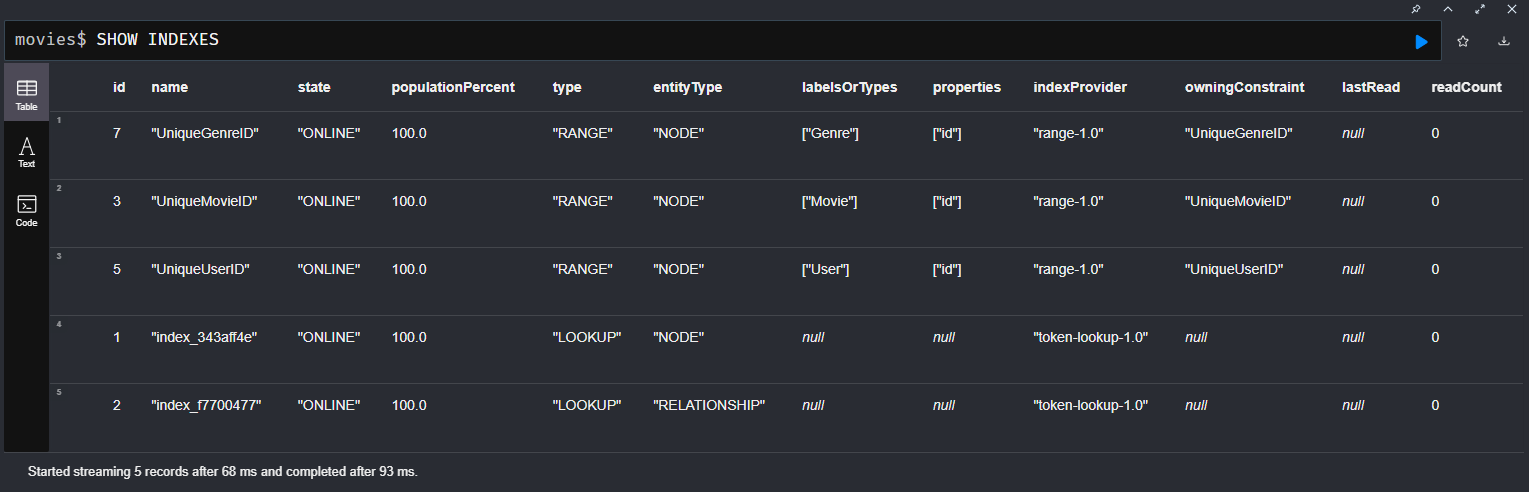

We add additional indexes to improve the performance of our queries

In [4]:
session.run(
    """
    CREATE INDEX RangeIndexYearRatings FOR ()-[r:RATED]-() ON (r.year)
    """
)
session.run(
    """
    CREATE INDEX RangeIndexMonthRatings FOR ()-[r:RATED]-() ON (r.month)
    """
)
session.run(
    """
    CREATE INDEX RangeIndexYearMovie FOR (m:Movie) ON (m.year)
    """
)
session.run(
    """
    CREATE TEXT INDEX TextIndexTitleMovie FOR (m:Movie) ON (m.title)
    """
)

For consistency check you can run this command:
```
neo4j-admin database check movies
```
The results should be like this one:  

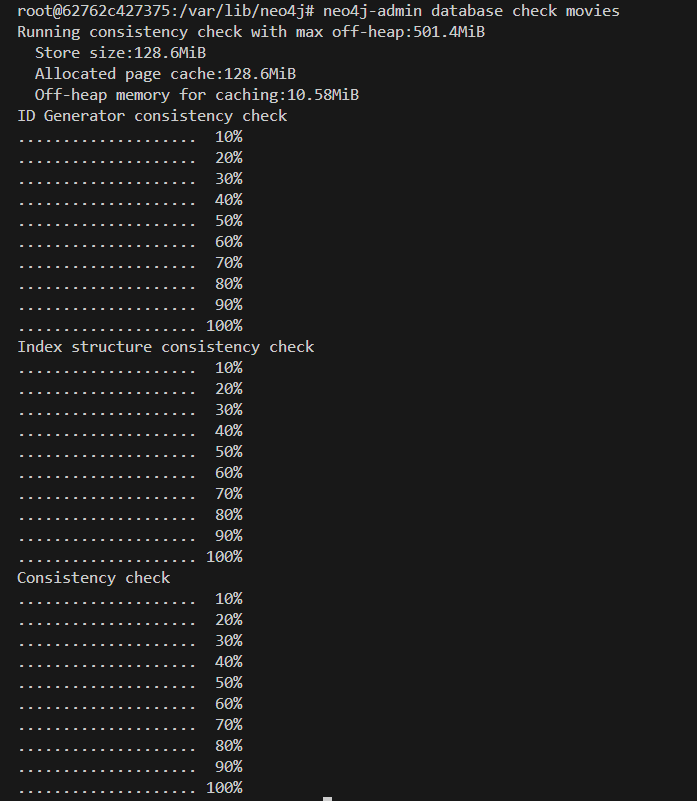